## Question 2.3

In [1]:
library('fBasics')
library(ggplot2)

data("DowJones30")
x <- DowJones30[,2:31]

   Epsilon Mean_Correlation Correlations_Increased
1  -0.0015        0.8149055                    851
2  -0.0012        0.8146608                    854
3  -0.0009        0.8144161                    858
4  -0.0006        0.8141717                    844
5  -0.0003        0.8139273                    847
6   0.0003        0.8134391                    -30
7   0.0006        0.8131952                    -30
8   0.0009        0.8129515                    -30
9   0.0012        0.8127079                    -12
10  0.0015        0.8124645                    -30


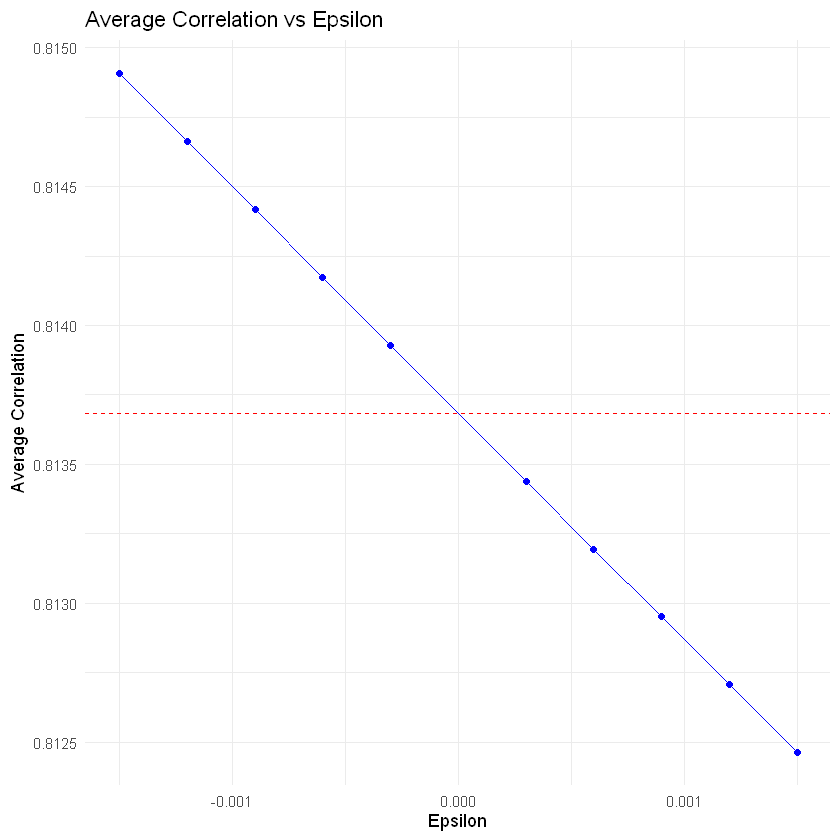

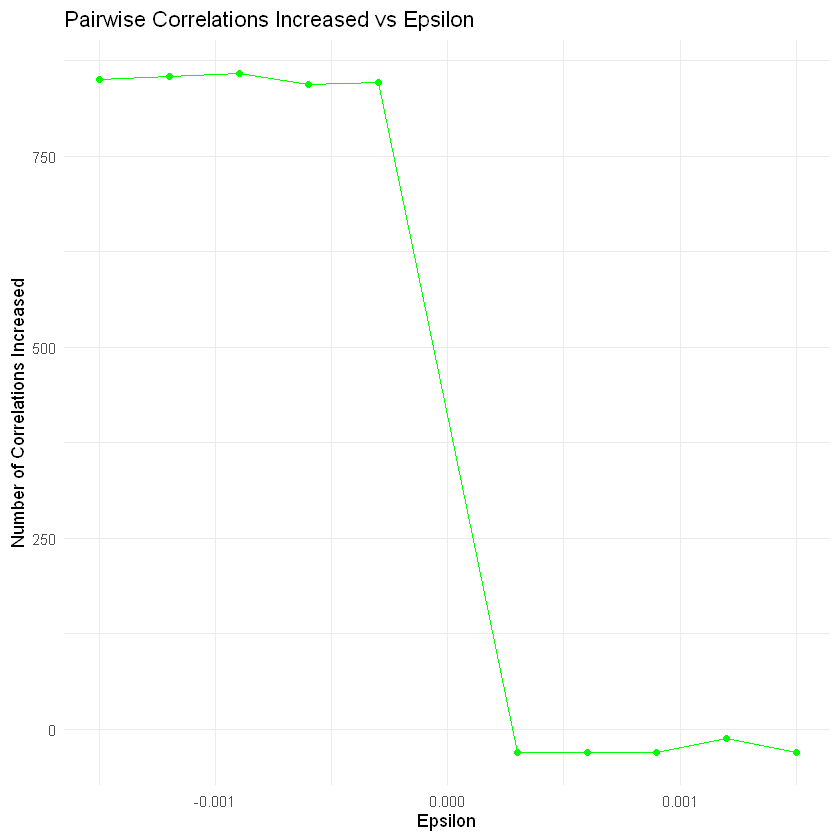

In [2]:
# Calculate the Pearson correlation matrix
R <- cor(x, method = "pearson")

# Perform spectral (eigen) decomposition
res <- eigen(R, symmetric = TRUE)
lambda <- res$values    # Eigenvalues
gamma <- res$vectors    # Eigenvectors

# Define epsilon values: 5 negative and 5 positive
epsilon_negatives <- seq(-0.0015, -0.0003, by = 0.0003)
epsilon_positives <- seq(0.0003, 0.0015, by = 0.0003)
epsilon_values <- c(epsilon_negatives, epsilon_positives)

# Initialize vectors to store results
mean_corr_original <- mean(R[upper.tri(R)])  # Exclude diagonal for mean correlation
mean_corr_new <- numeric(length(epsilon_values))
num_corr_increased <- numeric(length(epsilon_values))

# Loop over each epsilon value
for (i in seq_along(epsilon_values)) {
  epsilon <- epsilon_values[i]
  
  # Perturb the eigenvalues
  lambda_star <- lambda + epsilon
  
  # Ensure that all perturbed eigenvalues are positive
  if (any(lambda_star <= 0)) {
    warning(paste("Eigenvalues not all positive for epsilon =", epsilon, 
                  "- Skipping this epsilon value."))
    mean_corr_new[i] <- NA
    num_corr_increased[i] <- NA
    next
  }
  
  # Reconstruct the perturbed correlation matrix
  R_star <- gamma %*% diag(lambda_star) %*% t(gamma)
  
  # Normalize to get R_bar
  D <- diag(sqrt(diag(R_star)))
  D_inv <- solve(D)
  R_bar <- D_inv %*% R_star %*% D_inv
  
  # Calculate the mean correlation (excluding diagonal)
  mean_corr_new[i] <- mean(R_bar[upper.tri(R_bar)])
  
  # Calculate the number of pairwise correlations that increased (excluding diagonal)
  num_corr_increased[i] <- sum(R_bar > R, na.rm = TRUE) - nrow(R)
}

# Create a data frame to hold the results
results <- data.frame(
  Epsilon = epsilon_values,
  Mean_Correlation = mean_corr_new,
  Correlations_Increased = num_corr_increased
)

# Display the results
print(results)


# Plot for Average Correlation
ggplot(results, aes(x = Epsilon, y = Mean_Correlation)) +
  geom_line(color = "blue") +
  geom_point(color = "blue") +
  geom_hline(yintercept = mean_corr_original, linetype = "dashed", color = "red") +
  labs(title = "Average Correlation vs Epsilon",
       x = "Epsilon",
       y = "Average Correlation") +
  theme_minimal()

# Plot for Number of Correlations Increased
ggplot(results, aes(x = Epsilon, y = Correlations_Increased)) +
  geom_line(color = "green") +
  geom_point(color = "green") +
  labs(title = "Pairwise Correlations Increased vs Epsilon",
       x = "Epsilon",
       y = "Number of Correlations Increased") +
  theme_minimal()

First and foremost, let's discuss why $\lambda_1^*=\lambda_1+\epsilon$ may not yield a correlation matrix. Since $\epsilon$ is a real number, it can be negative. Adding a negative number can yield negative eigen values which would mean the resulting matrix $R^*=\Gamma \Delta^* \Gamma^T$ is not positive semi-definite. A valid correlation matrix must be positive semi-definite.

Regarding the results of eiven value changes. A positive $\epsilon$ decreases the average correlation. This makes sense since $\lambda_1=1+rho(n-1)$ and $\lambda_i=1-\rho$, so a larger $\lambda$ means smaller $\rho$. A negative $\epsilon$ yields larger average $\rho$. Of course, we need to be careful about the size of $\epsilon$ to keep all $\lambda$ positive after perturbation.